# NEMO model data plotting

## NEMO datasets 1h - MOTU map download link : https://data.marine.copernicus.eu/product/BALTICSEA_ANALYSISFORECAST_PHY_003_006/download?dataset=cmems_mod_bal_phy_anfc_PT1h-i



In [6]:
%matplotlib inline
import xarray as xr
from cmocean import cm as cmo  
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import gsw
from metpy.interpolate import cross_section
import glidertools as gt
import glob
import imageio
import imageio.v2 as imageio
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas
import cartopy.feature as cfeature
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

In [7]:
def gridlines(ax,lon_tick,lat_tick):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.5, linestyle='--',color='w',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    gl.xpadding=10
    gl.ypadding=10

### Open dataset

In [2]:
ds = xr.open_dataset('/home/nick/OC4920/SKAGERAK/data/wednesday_skag.nc') #muliple files

In [3]:
ds

<xarray.Dataset>
Dimensions:  (depth: 34, lat: 207, lon: 148, time: 49)
Coordinates:
  * depth    (depth) float32 0.5016 1.516 2.548 3.602 ... 166.2 184.6 203.9
  * lon      (lon) float32 9.041 9.069 9.097 9.125 ... 13.04 13.07 13.1 13.12
  * time     (time) datetime64[ns] 2023-05-04 2023-05-04T01:00:00 ... 2023-05-06
  * lat      (lat) float32 55.96 55.97 55.99 56.01 ... 59.34 59.36 59.37 59.39
Data variables:
    mlotst   (time, lat, lon) float32 ...
    wo       (time, depth, lat, lon) float32 ...
    sla      (time, lat, lon) float32 ...
    vo       (time, depth, lat, lon) float32 ...
    thetao   (time, depth, lat, lon) float32 ...
    uo       (time, depth, lat, lon) float32 ...
    so       (time, depth, lat, lon) float32 ...
Attributes: (12/20)
    comment:                                    Data on cropped native produc...
    grid_resolution:                            ~1 nautical mile (1min latitu...
    title:                                      CMEMS NEMO hourly model fields
    Conventions:                                CF-1.0
    source:                                     CMEMS BAL MFC NEMO model outp...
    contact:                                    servicedesk.cmems@mercator-oc...
    ...                                         ...
    FROM_ORIGINAL_FILE__northernmost_latitude:  65.89099
    FROM_ORIGINAL_FILE__westernmost_longitude:  9.041488
    FROM_ORIGINAL_FILE__southernmost_latitude:  53.008297
    start_date:                                 2023-05-08 13:00:00
    _CoordSysBuilder:                           ucar.nc2.dataset.conv.CF1Conv...
    history:                                    Data extracted from dataset h...

### Setting lon lat and checking the data

In [4]:
lon = ds.lon
lat = ds.lat

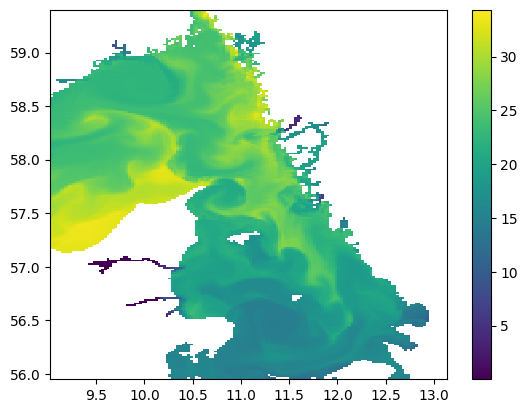

In [7]:
plt.pcolormesh(lon, lat, ds.so[0,0])
plt.colorbar()

## "for historical data" - NEMO monthly mean plots

In [ ]:
## 9.041488 is the last LON for NEMO
#cutting the area of interest 7,15 : 54,60
lon_min = 7
lon_max = 15
lat_min = 54
lat_max = 60

ds = ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
lon_area = ds.sel(lon=slice(lon_min, lon_max)).lon
lat_area = ds.sel(lat=slice(lat_min, lat_max)).lat

In [ ]:
#cutting the specific month and making the means from the temperature and depth==0
NEMO_mean_april_2021 = ds_area.sel(time='2021-04').isel(depth=0).mean(dim='time').thetao
NEMO_mean_april_2022 = ds_area.sel(time='2022-04').isel(depth=0).mean(dim='time').thetao
NEMO_mean_april_2023 = ds_area.sel(time='2023-04').isel(depth=0).mean(dim='time').thetao

In [ ]:
color_range = np.linspace(4,9,25)

fig, ax = plt.subplots(1,3 ,figsize=(18,16),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
img1 = ax[0].contourf(lon_area, lat_area,  NEMO_mean_april_2021, color_range, cmap=cmo.thermal)
ax[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[0].set_title('Mean SST - April 2021')
plt.colorbar(img1, orientation='horizontal', label='[$^{o}C$]', fraction=0.046, pad=0.04)

img2 = ax[1].contourf(lon_area, lat_area, NEMO_mean_april_2022, color_range, cmap=cmo.thermal)
ax[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[1].set_title('Mean SST - April 2022')
plt.colorbar(img2, orientation='horizontal', label='[$^{o}C$]', fraction=0.046, pad=0.04)

img3 = ax[2].contourf(lon_area, lat_area, NEMO_mean_april_2023, color_range, cmap=cmo.thermal)
ax[2].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[2].set_title('Mean SST - April 2023')
plt.colorbar(img3, orientation='horizontal', label='[$^{o}C$]', fraction=0.046, pad=0.04)


for axs in ax.flat:
    for k,spine in axs.spines.items():
        spine.set_zorder(12)
    gridlines(axs,1,3)


In [ ]:
#cutting the specific month and making the means from the salinity at 2m 
NEMO_mean_april_2021_sal = ds_area.sel(time='2021-04').isel(depth=2).mean(dim='time').so
NEMO_mean_april_2022_sal = ds_area.sel(time='2022-04').isel(depth=2).mean(dim='time').so
NEMO_mean_april_2023_sal = ds_area.sel(time='2023-04').isel(depth=2).mean(dim='time').so

In [ ]:
color_range = np.linspace(7,35,35)
colormap = cmo.haline
scale = '[$psu$]'

fig, ax = plt.subplots(1,3 ,figsize=(18,16),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
img1 = ax[0].contourf(lon_area, lat_area,  NEMO_mean_april_2021_sal, color_range, cmap=colormap)
ax[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[0].set_title('Mean Salinity - April 2021')
plt.colorbar(img1, orientation='horizontal', label=scale, fraction=0.046, pad=0.04)

img2 = ax[1].contourf(lon_area, lat_area, NEMO_mean_april_2022_sal, color_range, cmap=colormap)
ax[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[1].set_title('Mean Salinity - April 2022')
plt.colorbar(img2, orientation='horizontal', label=scale, fraction=0.046, pad=0.04)

img3 = ax[2].contourf(lon_area, lat_area, NEMO_mean_april_2023_sal, color_range, cmap=colormap)
ax[2].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[2].set_title('Mean Salinity - April 2023')
plt.colorbar(img3, orientation='horizontal', label=scale, fraction=0.046, pad=0.04)


for axs in ax.flat:
    for k,spine in axs.spines.items():
        spine.set_zorder(12)
    gridlines(axs,1,3)

In [ ]:
#cutting the specific month and making the means from the salinity at 22m -> 15th 
NEMO_mean_april_2021_sal_22 = ds_area.sel(time='2021-04').isel(depth=15).mean(dim='time').so
NEMO_mean_april_2022_sal_22 = ds_area.sel(time='2022-04').isel(depth=15).mean(dim='time').so
NEMO_mean_april_2023_sal_22 = ds_area.sel(time='2023-04').isel(depth=15).mean(dim='time').so

# differences between 2 and 22 meters in salinity
diff_2_22_2021 = NEMO_mean_april_2021_sal - NEMO_mean_april_2021_sal_22
diff_2_22_2022 = NEMO_mean_april_2022_sal - NEMO_mean_april_2022_sal_22
diff_2_22_2023 = NEMO_mean_april_2023_sal - NEMO_mean_april_2023_sal_22

In [ ]:
#### Difference in salinity between the two layers 2m - 22m 
color_range = np.linspace(-20,2,22)
colormap = cmo.balance
scale = '[$psu$]'
norm = mpl.colors.TwoSlopeNorm(0)

fig, ax = plt.subplots(1,3 ,figsize=(18,16),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
img1 = ax[0].contourf(lon_area, lat_area,  diff_2_22_2021, color_range, norm=norm, cmap=colormap)
ax[0].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[0].set_title('Mean Salinity - April 2021')
plt.colorbar(img1, orientation='horizontal', label=scale, fraction=0.046, pad=0.04)

img2 = ax[1].contourf(lon_area, lat_area, diff_2_22_2022, color_range, norm=norm, cmap=colormap)
ax[1].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[1].set_title('Mean Salinity - April 2022')
plt.colorbar(img2, orientation='horizontal', label=scale, fraction=0.046, pad=0.04)

img3 = ax[2].contourf(lon_area, lat_area, diff_2_22_2023, color_range, norm=norm, cmap=colormap)
ax[2].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
ax[2].set_title('Mean Salinity - April 2023')
plt.colorbar(img3, orientation='horizontal', label=scale, fraction=0.046, pad=0.04)


for axs in ax.flat:
    for k,spine in axs.spines.items():
        spine.set_zorder(12)
    gridlines(axs,1,3)

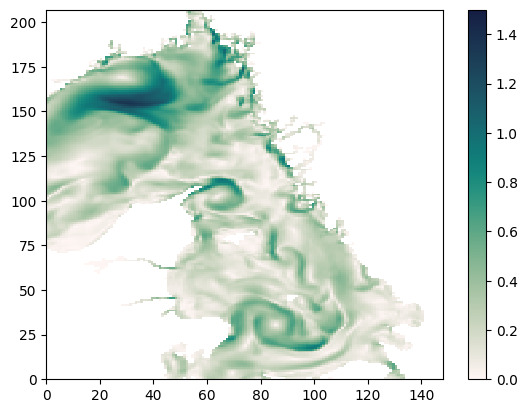

In [5]:
depth = 0
time = 0

## total velocity, using pythagorian theorem and combining both eastward and northward velocities
current_velocity = (ds['vo'].isel(time=time).isel(depth=depth)**2 + ds['uo'].isel(time=time).isel(depth=depth)**2)**0.5
plt.pcolormesh(current_velocity, cmap=cmo.tempo, vmin=0, vmax=1.5)
plt.colorbar()

## Loop to creat the frames individualy , can be used later for movies,gifs etc.

In [129]:
#Depth checker as to see at what depth we are plotting
ds.depth[16]

<xarray.DataArray 'depth' ()>
array(24.939384, dtype=float32)
Coordinates:
    depth    float32 24.94
Attributes: (12/16)
    units:                   m
    comment:                 
    unit_long:               meters
    reference:               sea_level SeaDataNet L111
    positive:                down
    uncertainty:             
    ...                      ...
    QC_indicator:            1
    valid_max:               712.02466
    axis:                    Z
    _ChunkSizes:             56
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down

In [29]:
#Time shape check, as to see how many times we should run the loops to create the frames 
ds.time.shape

(97,)

In [ ]:
#Create some salinity gradient



depth = 0
levels = [0,1,2,3,4]
colormap = cmo.tempo

for i in range(24):
    sal_grdnt =  ((np.gradient(ds['so'].isel(time=i).isel(depth=depth), axis=0))**2 + (np.gradient(ds['so'].isel(time=i).isel(depth=depth), axis=1))**2)**0.5
    fig, ax = plt.subplots(1, 1, figsize=(17,14),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
    
    pic = plt.pcolormesh(lon, lat, sal_grdnt, cmap=colormap, vmin=0,vmax=3)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
    ax.set_title('Salinity Gradient - NEMO') 
    plt.colorbar(pic, orientation='horizontal', label='[$psu$]', fraction=0.046, pad=0.04)
    contours = ax.contour(lon, lat, sal_grdnt, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contours, levels, inline=True, fmt='%1.0f', colors='white', fontsize=17)

    for k,spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(12)
        gridlines(ax,1,1)
    
    plt.savefig('NEMO_sal_grdnt_0m {0}.png'.format(i))
    plt.close()

In [14]:
#Create some northward velocity plots
for i in range(49):
    fig, ax = plt.subplots(1, 1, figsize=(17,14),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
    
    pic = ds['uo'].isel(time=i).isel(depth=0).plot(ax=ax,cmap=cmo.thermal,vmin=-0.7,vmax=0.7)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
    #ax.set_title('SST - NEMO') # removing it to allow dates titles fill in automatically
    #plt.colorbar(pic, orientation='horizontal', label='[$^{o}C$]', fraction=0.046, pad=0.04)
    contours = ax.contour(lon, lat, ds['uo'].isel(time=i).isel(depth=0), levels=(-1.5,-1,-0.5,-0.25,0,0.25,0.5,1,1.5), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contours, levels=(-1.5,-1,-0.5,-0.25,0,0.25,0.5,1,1.5), inline=True, fmt='%1.0f', colors='white', fontsize=17)
   
    for k,spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(12)
        gridlines(ax,1,1)
    
    plt.savefig('NEMO_crnt_0m {0}.png'.format(i))
    plt.close()

In [8]:
# Create some total velocity plots 
depth = 0
levels = [0,0.5,1,1.5]
colormap = cmo.tempo

for i in range(24):
    sal_grdnt =  (ds['vo'].isel(time=i).isel(depth=depth)**2 + ds['uo'].isel(time=i).isel(depth=depth)**2)**0.5
    fig, ax = plt.subplots(1, 1, figsize=(17,14),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
    
    pic = plt.pcolormesh(lon, lat, sal_grdnt, cmap=colormap, vmin=0,vmax=1.5)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
    ax.set_title('Total VElocity - NEMO') 
    plt.colorbar(pic, orientation='horizontal', label='[sample]', fraction=0.046, pad=0.04)
    contours = ax.contour(lon, lat, sal_grdnt, levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contours, levels, inline=True, fmt='%1.0f', colors='white', fontsize=17)

    for k,spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(12)
        gridlines(ax,1,1)
    
    plt.savefig('NEMO_total_velovity_0m {0}.png'.format(i))
    plt.close()

In [24]:
#Create some temperature plots for the GIF
for i in range(49):
    fig, ax = plt.subplots(1, 1, figsize=(17,14),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
    
    pic = ds['thetao'].isel(time=i).isel(depth=8).plot(ax=ax,cmap=cmo.thermal,vmin=5,vmax=10)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
    #ax.set_title('SST - NEMO')  # removing it to allow dates titles fill in automatically
    #plt.colorbar(pic, orientation='horizontal', label='[$^{o}C$]', fraction=0.046, pad=0.04)
    contours = ax.contour(lon, lat, ds['thetao'].isel(time=i).isel(depth=8), levels=(5,6,7,8,9,10), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contours, levels=(5,6,7,8,9,10), inline=True, fmt='%1.0f', colors='white', fontsize=17)
   
    for k,spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(12)
        gridlines(ax,1,1)
    
    plt.savefig('NEMO_temp_8m {0}.png'.format(i))
    plt.close()

In [20]:
#Create some salinity(at 5m) plots for the GIF
depth = 12
levels = [20,25,30,35]
variable = ds['so']

for i in range(49):
    fig, ax = plt.subplots(1, 1, figsize=(17,14),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
    
    pic = variable.isel(time=i).isel(depth=depth).plot(ax=ax,cmap=cmo.haline,vmin=18,vmax=36)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
    #ax.set_title('SST - NEMO')  # removing it to allow dates titles fill in automatically
    #plt.colorbar(pic, orientation='horizontal', label='[$psu$]', fraction=0.046, pad=0.04)
    contours = ax.contour(lon, lat, variable.isel(time=i).isel(depth=depth), levels=levels, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contours, levels, inline=True, fmt='%1.0f', colors='white', fontsize=17)

    for k,spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(12)
        gridlines(ax,1,1)
    
    plt.savefig('NEMO_sal_15m {0}.png'.format(i))
    plt.close()

In [ ]:
#create some total velocity maps : 
for i in range(49):
    fig, ax = plt.subplots(1, 1, figsize=(17,14),subplot_kw={'projection':ccrs.PlateCarree()},constrained_layout=True)
    
    pic = ds['uo'].isel(time=i).isel(depth=0).plot(ax=ax,cmap=cmo.thermal,vmin=-0.7,vmax=0.7)
    
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3) 
    #ax.set_title('SST - NEMO') # removing it to allow dates titles fill in automatically
    #plt.colorbar(pic, orientation='horizontal', label='[$^{o}C$]', fraction=0.046, pad=0.04)
    contours = ax.contour(lon, lat, ds['uo'].isel(time=i).isel(depth=0), levels=(-1.5,-1,-0.5,-0.25,0,0.25,0.5,1,1.5), colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
    plt.clabel(contours, levels=(-1.5,-1,-0.5,-0.25,0,0.25,0.5,1,1.5), inline=True, fmt='%1.0f', colors='white', fontsize=17)
   
    for k,spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(12)
        gridlines(ax,1,1)
    
    plt.savefig('NEMO_crnt_0m {0}.png'.format(i))
    plt.close()

In [6]:
#make a GIF with the plots

def gifmaker(impath,savepath,duration):

    filenames = []
    for file in glob.glob(impath): # Specify where the images at
        filenames.append(file)
    filenames.sort(key=os.path.getmtime)

    images = list(map(lambda filename: imageio.imread(filename), filenames))

    imageio.mimsave(os.path.join(savepath), images, duration = duration) # modify duration as needed



impath = "/home/nick/OC4920/SKAGERAK/salinity/*.png"
savepath = "/home/nick/OC4920/SKAGERAK/my_gif.gif"
duration = 0.3 # in seconds per frame ~ 0.3 - 0.5
gifmaker(impath, savepath, duration)